In [1]:
%tensorflow_version 2.x
%matplotlib inline

In [2]:
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dense, Flatten
from tensorflow import test, device
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

In [3]:
import json
import numpy as np

data = []
with open('Sarcasm_Headlines_Dataset.json','r') as json_file:
    for l in json_file:
        data.append(list(json.loads(l).values()))

data = np.array(data)
x_data = data[:, 1]
y_data = data[:, 2]

data2 = []
with open('Sarcasm_Headlines_Dataset_v2.json','r') as json_file:
    for l in json_file:
        data2.append(list(json.loads(l).values()))

data2 = np.array(data2)
x2_data = data2[:, 1]
y2_data = data2[:, 0]

data[:10]

array([['https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
        "former versace store clerk sues over secret 'black code' for minority shoppers",
        '0'],
       ['https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
        "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
        '0'],
       ['https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
        "mom starting to fear son's web series closest thing she will have to grandchild",
        '1'],
       ['https://politics.theonion.com/boehner-just-wants-wife-to-listen-not-come-up-with-alt-1819574302',
        'boehner just wants wife to listen, not come up with alternative debt-reduction ideas',
        '1'],
       ['https://www.huffingtonpost.com/entry/jk-rowling-wishes-snape-happy-birthday_us_569117c4e4b0cad15e64fdcb',
        'j.k. rowling wishes snape happy birthday

In [4]:
data2[:10]

array([['1',
        'thirtysomething scientists unveil doomsday clock of hair loss',
        'https://www.theonion.com/thirtysomething-scientists-unveil-doomsday-clock-of-hai-1819586205'],
       ['0',
        'dem rep. totally nails why congress is falling short on gender, racial equality',
        'https://www.huffingtonpost.com/entry/donna-edwards-inequality_us_57455f7fe4b055bb1170b207'],
       ['0', 'eat your veggies: 9 deliciously different recipes',
        'https://www.huffingtonpost.com/entry/eat-your-veggies-9-delici_b_8899742.html'],
       ['1', 'inclement weather prevents liar from getting to work',
        'https://local.theonion.com/inclement-weather-prevents-liar-from-getting-to-work-1819576031'],
       ['1',
        "mother comes pretty close to using word 'streaming' correctly",
        'https://www.theonion.com/mother-comes-pretty-close-to-using-word-streaming-cor-1819575546'],
       ['0', 'my white inheritance',
        'https://www.huffingtonpost.com/entry/my-wh

In [5]:
x_data = np.concatenate((x_data, x2_data))
y_data = np.concatenate((y_data, y2_data))

In [6]:
x_data.shape

(55328,)

In [7]:
y_data

array(['0', '0', '1', ..., '0', '1', '1'], dtype='<U926')

In [8]:
y_data = y_data.astype(np.uint8)
y_data

array([0, 0, 1, ..., 0, 1, 1], dtype=uint8)

In [9]:
t = Tokenizer()
t.fit_on_texts(x_data)
x_tokenized = t.texts_to_sequences(x_data)

In [10]:
lengths = [len(headline) for headline in x_tokenized]
print('Longest headline: {} Shortest headline: {}'.format(max(lengths), min(lengths)))

Longest headline: 152 Shortest headline: 2


(array([5.3518e+04, 1.8030e+03, 6.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  2.,  17.,  32.,  47.,  62.,  77.,  92., 107., 122., 137., 152.]),
 <a list of 10 Patch objects>)

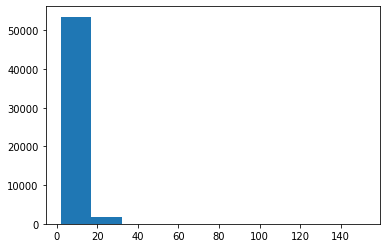

In [11]:
import matplotlib
matplotlib.pyplot.hist(lengths)

In [12]:
cutoff = 14
print('{} headlines out of {} are over {}.'.format(
    sum([1 for length in lengths if length > cutoff]), 
    len(lengths), 
    cutoff))

4936 headlines out of 55328 are over 14.


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_tokenized, y_data, test_size=0.3, random_state=42)

In [14]:
x_train_padded = sequence.pad_sequences(x_train, maxlen=cutoff)
x_test_padded = sequence.pad_sequences(x_test, maxlen=cutoff)

In [15]:
model = Sequential()
model.add(Embedding(input_dim=len(x_train), output_dim=100, input_length=cutoff))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 14, 100)           3872900   
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 32)            16032     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 32)             5152      
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               24704     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 3,918,917
Trainable params: 3,918,917
Non-trainable params: 0
______________________________________________

In [24]:
# Train using GPU acceleration
# (see https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=Y04m-jvKRDsJ)
device_name = test.gpu_device_name()
if device_name != '/device:GPU:0':
    print(
        '\n\nThis error most likely means that this notebook is not '
        'configured to use a GPU.  Change this in Notebook Settings via the '
        'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
    raise SystemError('GPU device not found')

with device('/device:GPU:0'):
    model.fit(x_train_padded, y_train, epochs=1, batch_size=64)  # 5 total epochs

606/606 [==============================] - 22s 37ms/step - loss: 1.8232e-04 - binary_accuracy: 1.0000


In [17]:
with device('/device:GPU:0'):
    scores = model.evaluate(x_test_padded, y_test)
print('loss: {} accuracy: {}'.format(*scores))  # post epoch 1

519/519 [==============================] - 1s 2ms/step - loss: 0.1703 - binary_accuracy: 0.9346
loss: 0.17026230692863464 accuracy: 0.9346346259117126


In [19]:
with device('/device:GPU:0'):
    scores = model.evaluate(x_test_padded, y_test)
print('loss: {} accuracy: {}'.format(*scores))  # post epoch 2

519/519 [==============================] - 1s 2ms/step - loss: 0.1504 - binary_accuracy: 0.9481
loss: 0.15044161677360535 accuracy: 0.948129415512085


In [21]:
with device('/device:GPU:0'):
    scores = model.evaluate(x_test_padded, y_test)
print('loss: {} accuracy: {}'.format(*scores))  # post epoch 3

519/519 [==============================] - 1s 2ms/step - loss: 0.2268 - binary_accuracy: 0.9526
loss: 0.22676394879817963 accuracy: 0.9525874853134155


In [23]:
with device('/device:GPU:0'):
    scores = model.evaluate(x_test_padded, y_test)
print('loss: {} accuracy: {}'.format(*scores))  # post epoch 4

519/519 [==============================] - 1s 2ms/step - loss: 0.2543 - binary_accuracy: 0.9533
loss: 0.25429195165634155 accuracy: 0.9532501697540283


In [25]:
with device('/device:GPU:0'):
    scores = model.evaluate(x_test_padded, y_test)
print('loss: {} accuracy: {}'.format(*scores))  # post epoch 5

519/519 [==============================] - 1s 2ms/step - loss: 0.2830 - binary_accuracy: 0.9540
loss: 0.2830181121826172 accuracy: 0.954033374786377


In [26]:
predictions_test_onehot = model.predict(x_test_padded)
predictions_test = np.round(predictions_test_onehot)  # use round not argmax
precision_recall_fscore_support(y_true=y_test, y_pred=predictions_test)

(array([0.95179521, 0.95669967]),
 array([0.96321633, 0.94337412]),
 array([0.95747171, 0.94999017]),
 array([8917, 7682]))

This was surprisingly super accurate. I guess machine learning is powerful enough even to distinguish between fact and satire. Additionally, even though the loss was extremely small and the accuracy 100% for the train set, the model continued to improve its accuracy on the test set, even if by very small amounts.

Let's test it on some recent theonion.com headlines.

In [28]:
headline = t.texts_to_sequences(['Arkansas Legislator Warns Loophole In New Law Could Still Allow Trans Youth To Exist'])
headline = sequence.pad_sequences(headline, maxlen=cutoff)
headline

array([[ 4128, 15021,   451, 11249,     4,    11,   283,    85,    71,
         1688,   786,  1093,     1,  3095]], dtype=int32)

In [29]:
model.predict(headline)

array([[0.999972]], dtype=float32)

Hmm, in a previous attempt where the model had a 94.3% accuracy, it did not get this one right, but this around it did work out.

In [30]:
headline = t.texts_to_sequences(['U.S. Criticized For Giving $1 Trillion To Military Contractor To Develop Hat That Didn’t Work'])
headline = sequence.pad_sequences(headline, maxlen=cutoff)
model.predict(headline)

array([[0.99012834]], dtype=float32)

In [31]:
headline = t.texts_to_sequences(['Billboard With Happy Family Inspires Estranged Dad To Almost Call Kids'])
headline = sequence.pad_sequences(headline, maxlen=cutoff)
model.predict(headline)

array([[0.9998766]], dtype=float32)

Both these headlines worked for both models.

Now a headline from the NYT.

In [36]:
headline = t.texts_to_sequences(['F.D.A. Will Allow Abortion Pills By Mail During the Pandemic'])
headline = sequence.pad_sequences(headline, maxlen=cutoff)
model.predict(headline)

array([[1.6032559e-06]], dtype=float32)

In [37]:
headline = t.texts_to_sequences(['Anti-Gay Bias Hindered Toronto Police as Serial Killer Roamed'])
headline = sequence.pad_sequences(headline, maxlen=cutoff)
model.predict(headline)

array([[2.5949927e-07]], dtype=float32)

In [32]:
model.save("SarcasmModel")

INFO:tensorflow:Assets written to: SarcasmModel/assets


In [34]:
# https://stackoverflow.com/questions/50453428/how-do-i-download-multiple-files-or-an-entire-folder-from-google-colab
!zip -r /content/SarcasmModel.zip /content/SarcasmModel

  adding: content/SarcasmModel/ (stored 0%)
  adding: content/SarcasmModel/assets/ (stored 0%)
  adding: content/SarcasmModel/variables/ (stored 0%)
  adding: content/SarcasmModel/variables/variables.data-00000-of-00001 (deflated 24%)
  adding: content/SarcasmModel/variables/variables.index (deflated 65%)
  adding: content/SarcasmModel/saved_model.pb (deflated 87%)


In [35]:
from google.colab import files
files.download("/content/SarcasmModel.zip") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>